In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import datetime
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.manifold import TSNE
import matplotlib.cm as cm
warnings.filterwarnings('ignore')

## 1. Load Data

In [2]:
rp = pd.read_csv("ravenpack_all.csv",encoding = 'unicode_escape')

In [3]:
entity_id = rp.RP_ENTITY_ID.unique()

In [4]:
with open('readme.txt', 'w') as f:
    f.write('\n'.join(entity_id))

Submit a query to Ravenpack database to get the mapping file

In [5]:
rp_map = pd.read_csv("ravenpack_map.csv",encoding = 'unicode_escape')

In [6]:
ticker = rp_map[rp_map['DATA_TYPE'] == "TICKER"].DATA_VALUE.unique()

In [7]:
with open('readme2.txt', 'w') as f:
    f.write('\n'.join(ticker))

Submit a query to CRSP database to get stock price

In [8]:
crsp = pd.read_csv("crsp.csv",encoding = 'unicode_escape')

## 2. Data Preprocessing

### (1) Get the price dataframe, with index = date, columns = ticker

In [9]:
price = crsp.copy()

In [10]:
price = price[['date','TICKER','PRC']]

In [11]:
price['date'] = pd.to_datetime(price['date'],format='%Y%m%d')

In [12]:
price = price[price['TICKER'].notna()]

In [13]:
price = price.pivot_table(index = 'date', columns = 'TICKER', values = 'PRC')

### (2) Add industry information to companies

In [14]:
SIC_CODE = pd.read_excel('SIC code meaning.xlsx')
SIC_CODE.head()

,SIC Code,Office,Industry Title
0,100,Office of Life Sciences,AGRICULTURAL PRODUCTION-CROPS
1,200,Office of Life Sciences,AGRICULTURAL PROD-LIVESTOCK & ANIMAL SPECIALTIES
2,700,Office of Life Sciences,AGRICULTURAL SERVICES
3,800,Office of Life Sciences,FORESTRY
4,900,Office of Life Sciences,"FISHING, HUNTING AND TRAPPING"


In [15]:
def string_filter(x):
    if str(x).isalpha():
        return False
    else:
        return True

In [16]:
returns = crsp[['date','TICKER','RET', 'SICCD']].copy()
returns = returns.merge(SIC_CODE, how = 'left', left_on='SICCD', right_on='SIC Code')
returns.drop(['Office', 'SICCD'], axis = 1, inplace = True)
returns.dropna(axis=0, inplace=True)
returns = returns[returns['RET'].apply(string_filter)]
returns['RET'] = returns['RET'].astype(float)
returns

,date,TICKER,RET,SIC Code,Industry Title
0,20000103,HON,-0.017335,3714.0,MOTOR VEHICLE PARTS & ACCESSORIES
1,20000104,HON,-0.017641,3714.0,MOTOR VEHICLE PARTS & ACCESSORIES
2,20000105,HON,-0.013468,3714.0,MOTOR VEHICLE PARTS & ACCESSORIES
3,20000106,HON,0.019340,3714.0,MOTOR VEHICLE PARTS & ACCESSORIES
4,20000107,HON,0.053571,3714.0,MOTOR VEHICLE PARTS & ACCESSORIES
...,...,...,...,...,...
2668088,20190612,BORN,-0.053693,6799.0,"INVESTORS, NEC"
2668089,20190613,BORN,-0.051396,6799.0,"INVESTORS, NEC"
2668090,20190614,BORN,-0.018925,6799.0,"INVESTORS, NEC"
2668091,20190617,BORN,-0.179355,6799.0,"INVESTORS, NEC"


### (3) Set ticker_list

In [17]:
ticker_list = returns.TICKER.unique()

In [18]:
ticker_list = rp_map[rp_map['DATA_VALUE'].isin(ticker_list)].DATA_VALUE.unique()

In [19]:
price = abs(price[ticker_list])

In [20]:
price

TICKER,BT,ALA,ALU,CGO,FUJI,FUJIY,NMR,CISG,FANH,AF,...,ING,CX,VE,ABEV,ABV,TRR,CTEL,HKTV,EDN,DQ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,47.375,6.6250,26.4375,NaN,37.5000,NaN,NaN,NaN,12.1875,...,61.3125,27.3750,NaN,NaN,NaN,7.8125,20.500,NaN,NaN,NaN
2000-01-04,NaN,44.250,6.5625,25.8750,NaN,34.1875,NaN,NaN,NaN,11.9375,...,59.6875,25.3125,NaN,NaN,NaN,7.7500,19.500,NaN,NaN,NaN
2000-01-05,NaN,44.250,6.5000,25.1875,NaN,35.5625,NaN,NaN,NaN,11.8125,...,60.1875,25.1250,NaN,NaN,NaN,7.7500,19.125,NaN,NaN,NaN
2000-01-06,NaN,41.750,6.3125,25.8750,NaN,37.7500,NaN,NaN,NaN,11.8750,...,59.7500,24.9375,NaN,NaN,NaN,7.8125,14.500,NaN,NaN,NaN
2000-01-07,NaN,44.000,6.5000,27.7500,NaN,39.4375,NaN,NaN,NaN,11.8125,...,60.8125,25.3750,NaN,NaN,NaN,7.7500,16.000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25,NaN,NaN,NaN,13.6300,NaN,NaN,4.52,NaN,6.88,NaN,...,14.5400,5.9600,NaN,2.79,NaN,NaN,NaN,NaN,4.7999,37.25
2022-01-26,NaN,NaN,NaN,13.6900,NaN,NaN,4.42,NaN,6.83,NaN,...,14.7400,5.9800,NaN,2.75,NaN,NaN,NaN,NaN,4.7200,37.82
2022-01-27,NaN,NaN,NaN,13.5000,NaN,NaN,4.41,NaN,6.48,NaN,...,14.6600,5.9500,NaN,2.83,NaN,NaN,NaN,NaN,4.6200,36.07


In [21]:
returns = returns[returns['TICKER'].isin(ticker_list)]

In [22]:
returns

,date,TICKER,RET,SIC Code,Industry Title
5557,20100803,BWC,-0.033693,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC"
5558,20100804,BWC,0.050961,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC"
5559,20100805,BWC,0.049766,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC"
5560,20100806,BWC,-0.023096,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC"
5561,20100809,BWC,-0.014517,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC"
...,...,...,...,...,...
2668088,20190612,BORN,-0.053693,6799.0,"INVESTORS, NEC"
2668089,20190613,BORN,-0.051396,6799.0,"INVESTORS, NEC"
2668090,20190614,BORN,-0.018925,6799.0,"INVESTORS, NEC"
2668091,20190617,BORN,-0.179355,6799.0,"INVESTORS, NEC"


### (4) Visualize companies in each industry

Text(0.5, 1.0, 'Return')

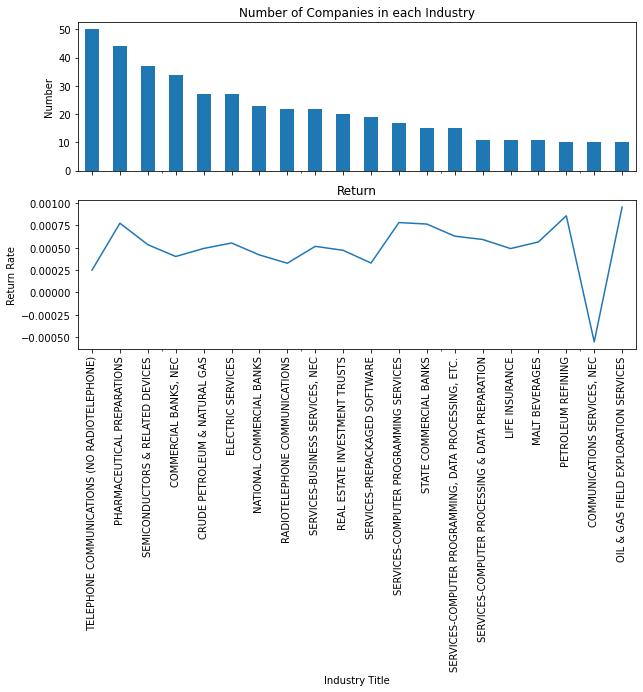

In [23]:
sector_info = returns.groupby('Industry Title').agg({'TICKER':'nunique', 'RET':'mean'}).sort_values('TICKER', ascending = False)
fig, ax = plt.subplots(2,1,sharex = True)
sector_info[sector_info['TICKER'] >= 10]['TICKER'].plot(kind = 'bar', figsize=(10,6), ax = ax[0])
ax[0].set_ylabel('Number')
ax[0].set_title('Number of Companies in each Industry')
sector_info[sector_info['TICKER'] >= 10]['RET'].plot(figsize=(10,6), ax = ax[1])
plt.xticks(rotation = 90)
ax[1].set_ylabel('Return Rate')
ax[1].set_title('Return')


### (5) Generate full_info table

In [24]:
use_rp_map = rp_map[rp_map['DATA_VALUE'].isin(ticker_list)]

In [25]:
use_rp_map = use_rp_map[use_rp_map['DATA_TYPE'] == "TICKER"]

In [26]:
use_rp_map = use_rp_map.groupby('DATA_VALUE').first()

In [27]:
use_rp_map.reset_index(inplace=True)

In [28]:
use_rp = rp.groupby('RP_ENTITY_ID').first()

In [29]:
full_data = pd.merge(use_rp_map,use_rp,left_on='RP_ENTITY_ID',right_on='RP_ENTITY_ID',how='left')

In [30]:
full_data

,DATA_VALUE,RP_ENTITY_ID,ENTITY_TYPE_x,DATA_TYPE,RANGE_START,RANGE_END,TIMESTAMP_UTC,RPNA_DATE_UTC,RPNA_TIME_UTC,ENTITY_TYPE_y,...,CSS,NIP,PEQ,BEE,BMQ,BAM,BCA,BER,ANL_CHG,MCQ
0,AAC,67A658,COMP,TICKER,2000-01-01,20070702.0,2000-01-11 14:17:24.000,20000111,14:17:24.000,COMP,...,50,41,50,50,50,50,50,50,50,50
1,AACG,E55727,COMP,TICKER,2019-10-17,NaN,2006-02-07 08:39:09.743,20060207,08:39:09.743,COMP,...,55,38,100,50,50,50,50,50,50,50
2,AAL,67A658,COMP,TICKER,2007-07-02,NaN,2000-01-11 14:17:24.000,20000111,14:17:24.000,COMP,...,50,41,50,50,50,50,50,50,50,50
3,AAUK,67A658,COMP,TICKER,2000-01-01,20070725.0,2000-01-11 14:17:24.000,20000111,14:17:24.000,COMP,...,50,41,50,50,50,50,50,50,50,50
4,ABB,5FC63E,COMP,TICKER,2000-01-01,NaN,2000-01-12 13:02:55.000,20000112,13:02:55.000,COMP,...,50,39,50,50,50,50,50,50,50,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,YOKU,2914B1,COMP,TICKER,2010-12-08,20160405.0,2008-03-17 06:00:00.000,20080317,06:00:00.000,COMP,...,50,54,50,50,50,50,50,50,50,50
600,YZC,58D16C,COMP,TICKER,2000-01-01,20170217.0,2000-04-17 10:52:00.000,20000417,10:52:00.000,COMP,...,46,69,50,50,0,0,50,100,50,0
601,ZNH,B23D1B,COMP,TICKER,2005-07-01,NaN,2000-01-04 05:00:00.000,20000104,05:00:00.000,COMP,...,50,26,50,50,50,50,50,50,50,50
602,ZTO,3940BA,COMP,TICKER,2016-10-24,NaN,2016-01-15 10:11:42.873,20160115,10:11:42.873,COMP,...,50,42,50,50,50,50,50,50,50,50


In [31]:
use_ticker = full_data[['DATA_VALUE', 'COUNTRY_CODE']].groupby('DATA_VALUE', as_index=False).last()
country_info = returns.merge(use_ticker, left_on='TICKER', right_on='DATA_VALUE', how = 'inner')\
    .groupby(['COUNTRY_CODE'])\
    .agg({'DATA_VALUE': 'nunique','RET':'mean'})\
    .sort_values('DATA_VALUE', ascending = False)
country_info.rename(columns={'DATA_VALUE':'TICKER'}, inplace = True)
country_info

,TICKER,RET
COUNTRY_CODE,,
GB,95,0.000369
CN,60,0.000583
FR,43,0.000509
AU,38,0.000743
DE,33,0.000375
KY,32,0.000707
JP,30,0.000253
BR,25,0.000626
NL,24,0.000475


In [32]:
full_info = returns.merge(use_ticker, left_on='TICKER', right_on='DATA_VALUE', how = 'inner')
full_info

,date,TICKER,RET,SIC Code,Industry Title,DATA_VALUE,COUNTRY_CODE
0,20100803,BWC,-0.033693,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC",BWC,DE
1,20100804,BWC,0.050961,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC",BWC,DE
2,20100805,BWC,0.049766,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC",BWC,DE
3,20100806,BWC,-0.023096,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC",BWC,DE
4,20100809,BWC,-0.014517,3569.0,"GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC",BWC,DE
...,...,...,...,...,...,...,...
1528408,20190612,BORN,-0.053693,6799.0,"INVESTORS, NEC",BORN,KY
1528409,20190613,BORN,-0.051396,6799.0,"INVESTORS, NEC",BORN,KY
1528410,20190614,BORN,-0.018925,6799.0,"INVESTORS, NEC",BORN,KY
1528411,20190617,BORN,-0.179355,6799.0,"INVESTORS, NEC",BORN,KY


### (6) Visualize companies in each country

Text(0.5, 1.0, 'Return')

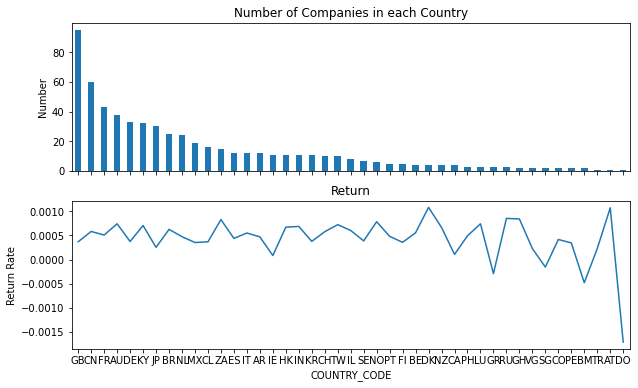

In [33]:
fig, ax = plt.subplots(2,1,sharex = True)
country_info['TICKER'].plot(kind = 'bar', figsize=(10,6), ax = ax[0])
ax[0].set_ylabel('Number')
ax[0].set_title('Number of Companies in each Country')
country_info['RET'].plot(figsize=(10,6), ax = ax[1])
ax[1].set_ylabel('Return Rate')
ax[1].set_title('Return')

### (7) Cluster

In [36]:
def apply_PCA(n_components, df, svd_solver='auto', random_state=0):

    pca = PCA(n_components=n_components, svd_solver=svd_solver, random_state=random_state)
    pca.fit(df)
    explained_variance = pca.explained_variance_

    # standardize
    X = preprocessing.StandardScaler().fit_transform(pca.components_.T)

    return X, explained_variance

In [37]:
# DBSCAN clustering algo
# eps: min distance for a sample to be within the cluster
# min_samples: min_samples to consider a cluster
# clustered_series_all: series with all tickers and labels
# clustered_series: series with tickers belonging to a cluster

def apply_DBSCAN(eps, min_samples, X, df_returns):

    clf = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')

    clf.fit(X)
    labels = clf.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("Clusters discovered using DBSCAN: %d" % n_clusters_)

    clustered_series_all = pd.Series(index=df_returns.columns, data=labels.flatten())
    clustered_series = clustered_series_all[clustered_series_all != -1]

    counts = clustered_series.value_counts()
    print("Pairs to evaluate using DBSCAN: %d" % (counts * (counts - 1) / 2).sum())

    return clustered_series_all, clustered_series, counts, clf

In [38]:
def apply_OPTICS(X, df_returns, min_samples, max_eps=2, xi=0.05, cluster_method='xi'):

    clf = OPTICS(min_samples=min_samples, max_eps=max_eps, xi=xi, metric='euclidean', cluster_method=cluster_method)

    clf.fit(X)
    labels = clf.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("Clusters discovered using OPTICS: %d" % n_clusters_)

    clustered_series_all = pd.Series(index=df_returns.columns, data=labels.flatten())
    clustered_series = clustered_series_all[clustered_series_all != -1]

    counts = clustered_series.value_counts()
    print("Pairs to evaluate using OPTICS: %d" % (counts * (counts - 1) / 2).sum())

    return clustered_series_all, clustered_series, counts, clf

In [39]:
# apply on "GB"
df = full_info[["date","TICKER","RET"]][full_info.COUNTRY_CODE == "GB"]
df = pd.pivot_table(df,index=["date"],columns=["TICKER"],fill_value=0)
df.columns = [el[1] for el in df.columns]

N_PRIN_COMPONENTS = 5
X, explained_variance = apply_PCA(N_PRIN_COMPONENTS, df, random_state=0)
print("Explained variance is ", explained_variance)

# clustered_series_all, clustered_series, counts, clf = apply_DBSCAN(0.10,3,X,df)

clustered_series_all, clustered_series, counts, clf = apply_OPTICS(X, df, min_samples=3, cluster_method='xi')



Explained variance is  [0.00573036 0.00352263 0.00259951 0.00196607 0.00171046]
Clusters discovered using OPTICS: 10
Pairs to evaluate using OPTICS: 82


In [40]:
def plot_TSNE(X, clf, clustered_series_all):
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=500).fit_transform(X)
    
    # visualization
    fig = plt.figure(1, facecolor='white', figsize=(15,15), frameon=True, edgecolor='black')
    plt.clf()
    
    ax = fig.add_subplot(1, 1, 1, alpha=0.9)
    
    ax.spines['left'].set_position('center')
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_position('center')
    ax.spines['bottom'].set_alpha(0.3)
    
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(which='major', labelsize=18)

  
    labels = clf.labels_
    x = X_tsne[(labels!=-1), 0]
    y = X_tsne[(labels!=-1), 1]
    tickers = list(clustered_series_all[clustered_series_all != -1].index)
    plt.scatter(
        x,
        y,
        s=300,
        alpha=0.75,
        c=labels[labels!=-1],
        cmap=cm.Paired
    )
    for i, ticker in enumerate(tickers):
        plt.annotate(ticker, (x[i]-15, y[i]+15), size=10)


    x = X_tsne[(clustered_series_all==-1).values, 0]
    y = X_tsne[(clustered_series_all==-1).values, 1]
    tickers = list(clustered_series_all[clustered_series_all == -1].index)

    plt.scatter(
        x,
        y,
        s=50,
        alpha=0.20,
        c='black'
    )
   
    plt.xlabel('t-SNE Dim_1', position=(0.92,0), size=10)
    plt.ylabel('t-SNE Dim_2', position=(0,0.92), size=10)
    ax.set_xticks(range(-500, 501, 1000))
    ax.set_yticks(range(-500, 501, 1000))
    plt.show()


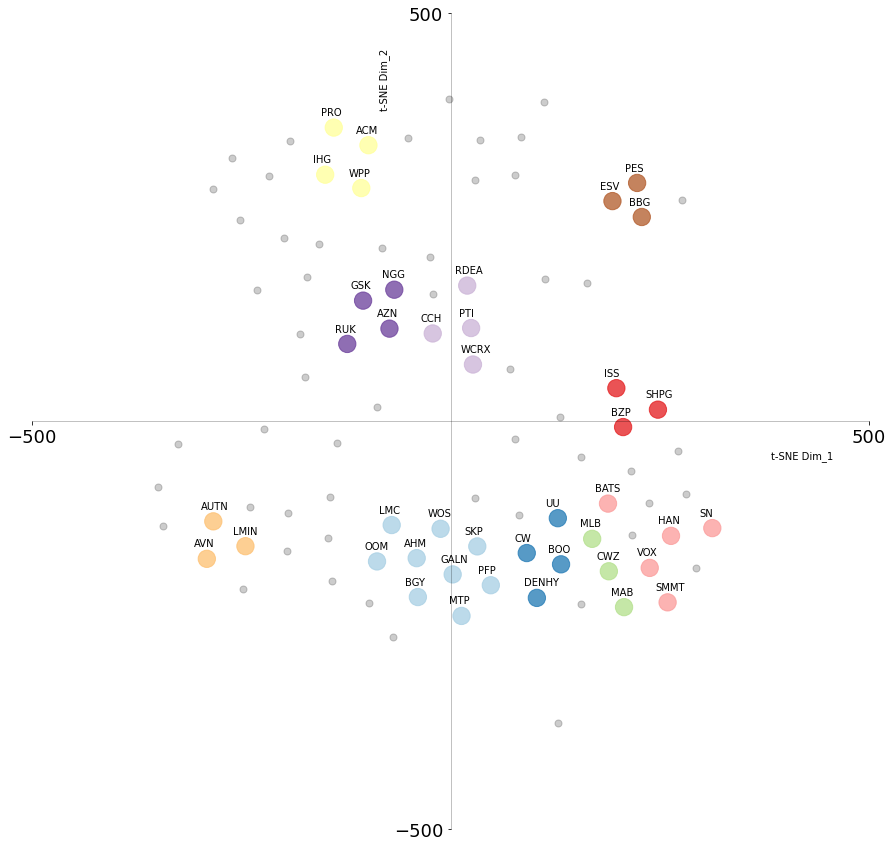

In [41]:
plot_TSNE(X,clf, clustered_series_all)